<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><img src="https://baobablab.github.io/bhb/images/collaborators/upsaclay.png" width="40%"></td>
    <td style="background-color:transparent;"><img src="https://baobablab.github.io/bhb/images/collaborators/cea.jpg" width="30%"></td>
  </tr>
</table> 
</div>

<center><h1>OpenBHB challenge: predicting brain age with site-effect removal</h1></center>

<center><h3>A data challenge on brain MRI images</h3></center>

**Authors**: Benoit Dufumier, Antoine Grigis, Julie Victor, Corentin Ambroise, Vincent Frouin, Edouard Duchesnay (CEA Saclay)



## Table of Content

1. [Prerequisites](#Libraries-Required)
2. [Introduction](#Introduction:-what-is-this-challenge-about-?)
3. [Available data](#Available-data)
4. [Evaluation metrics](#Evaluation-metrics)
5. [Submission](#Submitting-to-the-online-challenge:-ramp.studio)
6. [Where to start](#Where-to-start:-a-simple-MLP)
7. [Available baselines](#baselines)

**To download and run this notebook**: download the [full starting kit](https://github.com/ramp-kits/brain_age_with_site_removal), with all the necessary files.

## Libraries Required

This starting kit requires Python 3 and the following dependencies:

* `numpy`
* `scipy`
* `nibabel`
* `pandas`
* `scikit-learn`
* `nilearn`
* `matplolib`
* `seaborn`
* `jupyter`
* `progressbar`
* `torch`
* `ramp-workflow`

You can install the dependencies using `pip` with the following command-line:

```
pip install -U -r requirements.txt
```

If you are using `conda`, we provide an `environment.yml` file for similar usage:

```
conda env create -n ramp-brainage-siterm -f environment.yml
```

Then, you can activate/desactivate the conda environment using:

```
conda activate brain_age_siterm
conda deactivate
```

We will import all necessary libraries in this notebook beforehand:

In [9]:
from nilearn.plotting import plot_anat, plot_roi, plot_surf_roi
import joblib, sys
import nibabel
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, \
    mean_squared_error, balanced_accuracy_score
from nilearn.plotting import plot_anat, plot_roi, plot_surf_roi
from dataset.openbhb import OpenBHB
from problem import get_train_data
from dataset.openbhb import FeatureExtractor

## Introduction: what is this challenge about ?

Modelling brain development and maturation in the healthy population with Machine Learning (ML) from brain MRI images is a fundamental challenge. Biological processes implied are complex and highly heterogeneous between individuals, comprising both environmental and genetic variability across subjects. As a result, there is a need for large MRI datasets including subjects with a wide range of age. However, these datasets are often multi-sites (i.e images are acquired at different hospitals or acquisition centers across the world) and it induces a strong bias in current MRI data, due to difference between scanners (magnetic field, constructor, gradients, etc.)

Consequently, this challenge aims at building i) robust ML models that can accuratly predict chronological age from brain MRI while ii) removing non-biological site information from MRI images. We have designed this challenge in the context of **representation learning** and it promotes the development of **new ML and Deep Learning** algorithms.

More specifically, aging is associated with a cerebral altrophy (e.g grey matter atrophy, loss of brain volumes, etc.) . Each year, an adult typically loses 0.1% of grey matter. We will try to learn a predictor of the chronological age (true age) using T1 MRI images derived from a population of healthy control participants.

Such a predictor provides the expected **brain age** of a subject. Deviation from this expected brain age indicates acceleration or slowdown of the aging process which may be associated with a pathological neurobiological process (e.g Alzheimer's disease) or protective factor of aging.

For this challenge, we have used the OpenBHB dataset, composed of images coming from various sites, different MRI scanners and acquired under various settings. In order to predict properly the age of participants, one should deal with the site/scanner effect.

Now let's see what the OpenBHB dataset looks like !

## Available data

We propose to use the [openBHB dataset](https://baobablab.github.io/bhb). This dataset is composed of 3984 samples in the training set and 666 samples in the test set. A private test set is also used to estimate the final metric of the challenge (the 'challenge' metric).

We will first present the OpenBHB dataset (only training samples are public for this challenge) and we will next present the data formatting expected to run your submission locally (with `ramp-test`) before submitting it online in [ramp.studio](https://ramp.studio) (see next section).

### Data downloading and OpenBHB Dataset

You can first download the training data for this challenge on [IEEEDataport](https://ieee-dataport.org/open-access/openbhb-multi-site-brain-mri-dataset-age-prediction-and-debiasing).

Once downloaded, you can instantiate a Torch Dataloader `OpenBHB` object that will decompress the .zip files (if not already done):

In [3]:
root = "/neurospin/psy_sbox/bd261576/Datasets/OpenBHBChallenge/share/data_challenge"
# WARNING: for the first loading, it will unzip all files (if not already done).
# It may take some time (~1h) and disk memory (~240GB)
dataset = OpenBHB(root, split="train+test", preproc="vbm")

### Data exploration
All data have been preprocessed uniformly and checked. OpenBHB contains basically **3 main modalities** (Quasi-Raw, VBM and SBM) all extracted from T1w MRI. We'll review them in the following sections:

#### 1. Quasi-Raw

This modality is the rawest form of a T1w image as it includes both Gray Matter (GM), White Matter (WM) and CerebroSpinal Fluid (CSF) tissues only linearly registered to the MNI template. The spatial resolution is 1$mm^3$. In details, minimally preprocessed data were generated using [ANTS bias field correction](https://manpages.debian.org/testing/ants/N4BiasFieldCorrection.1.en.html), [FSL FLIRT](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT) affine registration with 9 degrees of freedom (no shearing) to the isotropic 1mm MNI template, and the application of a brain mask to remove non-brain tissues in the final images.

In [3]:
raw_dataset = OpenBHB(root, split="train+test", preproc="quasi_raw")
infos = raw_dataset.get_infos()
infos.head()

,participant_id,split,sex,age,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,100053248969,train,female,19.0,control,1434.357361,219.565569,678.230161,535.878459,3.0,1.0,0
1,100263562592,train,male,21.0,control,1558.161428,261.968669,756.742506,538.817738,3.0,1.0,1
2,100479214233,train,female,21.0,control,1418.050690,242.123816,686.814910,488.740580,3.0,1.0,2
3,100544064116,train,female,15.0,control,1304.233543,206.305238,667.809720,429.723510,3.0,1.0,4
4,101404752059,train,male,31.0,control,1660.856147,344.783456,703.484560,611.222413,3.0,1.0,1


Shape of quasi-raw data: (3984, 1, 182, 218, 182)


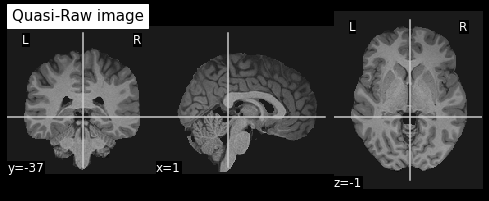

In [4]:
print("Shape of quasi-raw data: {}".format(raw_dataset.shape))
mni_template_raw = raw_dataset.get_metadata()
plot_anat(nibabel.Nifti1Image(raw_dataset[0][0][0], mni_template_raw.affine), title="Quasi-Raw image")

#### 2.Voxel-Based Morphometry (VBM)

Voxel-Based Morphometry (VBM) was performed with [CAT12](http://www.neuro.uni-jena.de/cat). The analysis stream includes non-linear spatial registration to the isotropic 1.5mm MNI template, Gray Matter (GM), White Matter (WM), and CerebroSpinal Fluid (CSF) tissues segmentation, bias correction of intensity non-uniformities, and segmentations modulation by scaling with the amount of volume changes due to spatial registration. VBM is most often applied to investigate the GM. The sensitivity of VBM in the WM is low, and usually, diffusion-weighted imaging is preferred for that purpose. For this reason, only the modulated GM images are used here.

For this modality, both whole-brain and Region-Of-Interests (ROI)-based measures are available. These ROI correspond to GM/CSF volumes averaged for each region of the [Neuromorphometrics atlas](https://scalablebrainatlas.incf.org/human/NMM1103). It includes 142 cortical and sub-cortical brain regions for GM and CSF volumes, thus totalizing 284 measures.

Let's explore both ROI and whole-brain VBM data.

In [5]:
dataset_vbm = OpenBHB(root, split="train+test", preproc="vbm")
dataset_vbm_roi = OpenBHB(root, split="train+test", preproc="vbm_roi")

In [6]:
print("Shape of VBM data: {}".format(dataset_vbm.shape))
print("Shape of ROI VBM data: {}".format(dataset_vbm_roi.shape))

Shape of VBM data: (3984, 1, 121, 145, 121)
Shape of ROI VBM data: (3984, 1, 284)


In [7]:
vbm_roi_data = dataset_vbm_roi.get_data()[0]
vbm_roi_data = vbm_roi_data.reshape(len(vbm_roi_data), -1)
pd.DataFrame(vbm_roi_data, columns=dataset_vbm_roi.get_metadata().ROI).head()

Dataset size to load (shape (3984, 1, 284)): 0.00 GB


ROI,l3thVen_GM_Vol,r3thVen_GM_Vol,l4thVen_GM_Vol,r4thVen_GM_Vol,lAcc_GM_Vol,rAcc_GM_Vol,lAmy_GM_Vol,rAmy_GM_Vol,lBst_GM_Vol,rBst_GM_Vol,...,lSupParLo_CSF_Vol,rSupParLo_CSF_Vol,lSupTemGy_CSF_Vol,rSupTemGy_CSF_Vol,lTemPo_CSF_Vol,rTemPo_CSF_Vol,lInfFroAngGy_CSF_Vol,rInfFroAngGy_CSF_Vol,lTemTraGy_CSF_Vol,rTemTraGy_CSF_Vol
0,0.053039,0.048369,0.060734,0.061854,0.459906,0.468918,0.938838,0.891076,0.218988,0.255043,...,5.511365,5.357252,1.530258,1.786721,3.190889,3.666309,1.019634,1.053287,0.230092,0.193845
1,0.054216,0.049066,0.068770,0.082101,0.583967,0.539738,1.083211,1.014388,0.413064,0.427760,...,5.217701,5.508973,2.500772,2.061796,4.058950,4.231397,1.425553,1.375922,0.342729,0.291603
2,0.049213,0.048180,0.048043,0.046824,0.434561,0.390073,0.964844,0.922083,0.181181,0.189534,...,5.593438,4.805681,2.252874,2.495137,3.615280,3.808025,1.380267,1.230373,0.228889,0.240335
3,0.046911,0.042503,0.060044,0.067260,0.466164,0.421475,0.833447,0.822256,0.270813,0.292323,...,4.411978,4.667454,1.847977,2.044174,3.102744,3.761645,1.094910,1.218654,0.192714,0.252183
4,0.055201,0.055941,0.070105,0.068939,0.409648,0.433441,1.165448,1.151983,0.380989,0.531479,...,7.087044,7.806519,2.004939,2.566109,5.512471,5.886167,1.526369,1.457631,0.268682,0.380045


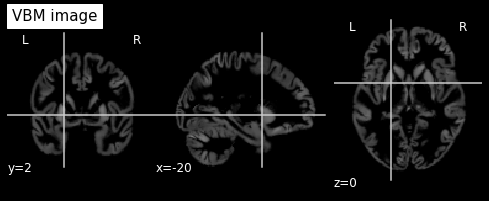

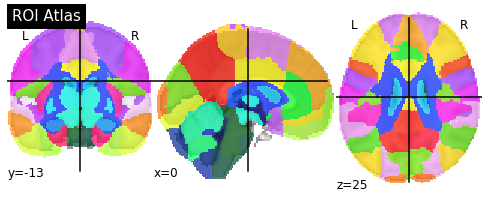

In [8]:
mni_template_vbm = dataset_vbm.get_metadata()
atlas_vbm = nibabel.load(os.path.join(os.path.abspath("."), "dataset", "neuromorphometrics.nii"))
plot_anat(nibabel.Nifti1Image(dataset_vbm[0][0][0], mni_template_vbm.affine), title="VBM image")
plot_roi(atlas_vbm, title="ROI Atlas")

#### 3. Surface-Based Morphometry (SBM)

SBM data correspond to cortical morphological measures extracted by [FreeSurfer "recon-all"](https://surfer.nmr.mgh.harvard.edu) at the brain surface. The analysis stream includes intensity normalization, skull stripping, segmentation of GM (pial) and WM, hemispheric-based tessellations, topology corrections and inflation, and registration to the "fsaverage" template.

In OpenBHB, both cortical thickness, surface area, GM volume, curvature measures are available i) on cortical mesh with 163842 vertives (FSL-Xhemi) and ii) based on 2 atlases, namely Destrieux and Desikan (see below). It consists essentially in 68 and 148 cortical regions for the Desikan and Destrieux atlas respectively (34 and 74 by hemisphere). Whole-brain high quality *fsaverage* mesh is also available with 163842 vertices.

In [9]:
# Loads whole-brain measures (e.g cortical thickness and curvatures on 187248 vertices)
dataset_fsl_xhemi = OpenBHB(root, split="train+test", preproc="fsl_xhemi")

In [10]:
# Loads ROI measures
dataset_fsl_destrieux = OpenBHB(root, split="train+test", preproc="fsl_destrieux_roi")
dataset_fsl_desikan = OpenBHB(root, split="train+test", preproc="fsl_desikan_roi")

In [11]:
print("Shape of ROI FSL (Detrieux atlas): {}".format(dataset_fsl_destrieux.shape))
print("Shape of ROI FSL (Desikan atlas): {}".format(dataset_fsl_desikan.shape))
print("Shape of XHEMI FSL: {}".format(dataset_fsl_xhemi.shape))

Shape of ROI FSL (Detrieux atlas): (3984, 7, 148)
Shape of ROI FSL (Desikan atlas): (3984, 7, 68)
Shape of XHEMI FSL: (3984, 8, 163842)


The 7 channels included here for ROI-based measures are detailed in *freesurfer_channels.txt*:

In [12]:
print(pd.read_csv(os.path.join(root, "resource", "freesurfer_channels.txt")))

                               surface_area_mm^2
0                        gray_matter_volume_mm^3
1                           average_thickness_mm
2                            thickness_stddev_mm
3      integrated_rectified_mean_curvature_mm^-1
4  integrated_rectified_gaussian_curvature_mm^-2
5                      intrinsic_curvature_index


For each channel, ROI measures are available for both Destrieux and Desikan atlases. For instance, for the surface area:

In [13]:
destrieux_roi_data = dataset_fsl_destrieux.get_data()[0]
pd.DataFrame(destrieux_roi_data[:,0,:], columns=dataset_fsl_destrieux.get_metadata().ROI).head()

Dataset size to load (shape (3984, 7, 148)): 0.02 GB


ROI,lh-G_and_S_frontomargin,lh-G_and_S_occipital_inf,lh-G_and_S_paracentral,lh-G_and_S_subcentral,lh-G_and_S_transv_frontopol,lh-G_and_S_cingul-Ant,lh-G_and_S_cingul-Mid-Ant,lh-G_and_S_cingul-Mid-Post,lh-G_cingul-Post-dorsal,lh-G_cingul-Post-ventral,...,rh-S_parieto_occipital,rh-S_pericallosal,rh-S_postcentral,rh-S_precentral-inf-part,rh-S_precentral-sup-part,rh-S_suborbital,rh-S_subparietal,rh-S_temporal_inf,rh-S_temporal_sup,rh-S_temporal_transverse
0,1086.0,1056.0,897.0,873.0,658.0,1672.0,862.0,946.0,415.0,196.0,...,1284.0,1101.0,1998.0,1313.0,782.0,255.0,825.0,1120.0,3910.0,195.0
1,908.0,1515.0,1022.0,974.0,549.0,1891.0,1097.0,1093.0,359.0,205.0,...,1497.0,1066.0,2145.0,779.0,1389.0,361.0,886.0,1170.0,5328.0,163.0
2,924.0,755.0,896.0,956.0,588.0,1359.0,892.0,885.0,457.0,197.0,...,1366.0,1040.0,1649.0,1310.0,688.0,131.0,818.0,830.0,4081.0,161.0
3,726.0,1205.0,859.0,923.0,623.0,1422.0,940.0,776.0,411.0,262.0,...,1768.0,941.0,1639.0,1253.0,659.0,316.0,758.0,866.0,4067.0,235.0
4,909.0,1416.0,955.0,1094.0,589.0,2068.0,1004.0,1043.0,562.0,268.0,...,1480.0,1292.0,1824.0,1107.0,912.0,285.0,836.0,882.0,5094.0,280.0


In [14]:
desikan_roi_data = dataset_fsl_desikan.get_data()[0]
pd.DataFrame(desikan_roi_data[:,0,:], columns=dataset_fsl_desikan.get_metadata().ROI).head()

Dataset size to load (shape (3984, 7, 68)): 0.01 GB


ROI,lh-bankssts,lh-caudalanteriorcingulate,lh-caudalmiddlefrontal,lh-cuneus,lh-entorhinal,lh-fusiform,lh-inferiorparietal,lh-inferiortemporal,lh-isthmuscingulate,lh-lateraloccipital,...,rh-rostralanteriorcingulate,rh-rostralmiddlefrontal,rh-superiorfrontal,rh-superiorparietal,rh-superiortemporal,rh-supramarginal,rh-frontalpole,rh-temporalpole,rh-transversetemporal,rh-insula
0,1023.0,580.0,2426.0,1650.0,425.0,3032.0,4721.0,3255.0,1050.0,5317.0,...,670.0,6834.0,7424.0,5254.0,3279.0,3673.0,311.0,496.0,308.0,1920.0
1,1277.0,728.0,2148.0,1477.0,527.0,3606.0,5532.0,4796.0,999.0,6270.0,...,698.0,6415.0,7861.0,5237.0,4021.0,4195.0,370.0,550.0,324.0,2647.0
2,975.0,625.0,2656.0,1119.0,306.0,2894.0,4924.0,3480.0,1012.0,4150.0,...,714.0,6288.0,7443.0,5751.0,3822.0,4035.0,338.0,430.0,318.0,2423.0
3,1175.0,667.0,2092.0,1762.0,355.0,3088.0,5048.0,3089.0,1098.0,5821.0,...,582.0,5976.0,6934.0,4977.0,3826.0,3415.0,316.0,510.0,336.0,2162.0
4,1034.0,560.0,2506.0,1824.0,436.0,3782.0,5311.0,3412.0,1336.0,6184.0,...,848.0,5625.0,7683.0,5397.0,4608.0,4518.0,369.0,476.0,395.0,2685.0


As for whole-brain measures (computed symmetrically on right and left hemisphere with FSL Xhemi), we have 8 channels corresponding to:

In [15]:
print(dataset_fsl_xhemi.get_metadata())

   lh.aparc.annot.mgz
0         lh.curv.mgz
1         lh.sulc.mgz
2    lh.thickness.mgz
3  rh.aparc.annot.mgz
4         rh.curv.mgz
5         rh.sulc.mgz
6    rh.thickness.mgz


Commonly with FreeSurfer, "lh" designates the left hemisphere and "rh" the right hemisphere. In this case, we have, for each hemisphere (`lh` and `rh`):
1. `aparc` is the Desikan-Killiany cortical parcellation, i.e for each vertex it gives the ROI this vertex belongs to as an integer (using Desikan atlas)
2. `sulc` essentially measures the depth/height of each vertex above the average surface. Specifically, it is the integrated dot product of the movement vector with the (outwards pointing) surface normal during inflation.
3. `curv` is the smoothed mean curvature, i.e it means how much the cortical surface is folded in each vertex
4. `thickness` is the cortical thickness on each vertex

It results in 8 channels and 163842 vertices. FSL Xhemi essentially gives measures of the cortical surface geometry and it is then complementary to the VBM modality that essentially gives gray matter volumes. In particular, the geometry of folding patterns does not change during ageing so it can be closely related to individual genetic.

More details about the meaning of `sulc`, `curv` and `thickness` can be found here: [https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial)

We can easily visualize the cortical surface Destrieux atlas the ROI-based measures were computed on:


Dataset created in /neurospin/psy_sbox/bd261576/Datasets/OpenBHBChallenge/share/data_challenge/atlas/destrieux_surface



 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


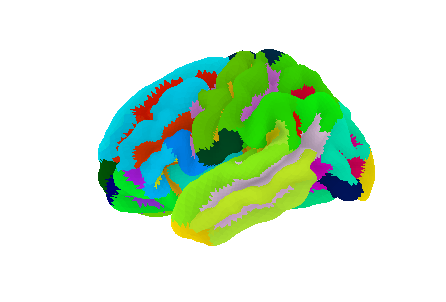

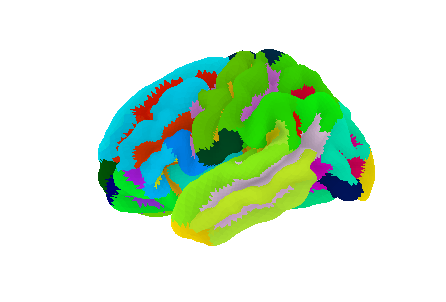

In [16]:
from nilearn import datasets

destrieux_atlas = datasets.fetch_atlas_surf_destrieux(os.path.join(root, "atlas"))
parcellation = destrieux_atlas['map_left']

# Retrieve fsaverage5 surface dataset for the plotting background
fsaverage = datasets.fetch_surf_fsaverage(data_dir=os.path.join(root, "atlas"))
plot_surf_roi(fsaverage['pial_left'], roi_map=parcellation, hemi='left', view='lateral',
              bg_map=fsaverage['sulc_left'], bg_on_data=True, darkness=.5)

### Local training/test splits

OpenBHB comes with a local training/test split that will be used for your local RAMP submission (to test your model locally). This split is derived from the official OpenBHB training set used in this challenge. In order to build accurate estimator (e.g with hyper-parameters selection), we recommend using these pre-defined splits although **it is not mandatory** and other user-defined splits may be used based on the official OpenBHB training set. Local training and test splits are easily accessible with:

In [17]:
train = OpenBHB(root, split="train", preproc="vbm")
print("Training VBM images: {}".format(train.shape))
test = OpenBHB(root, split="test", preproc="vbm")
print("Internal Testing VBM images: {}".format(test.shape))
ext_test = OpenBHB(root, split="external_test", preproc="vbm")
print("External Testing VBM images: {}".format(ext_test.shape))

Training VBM images: (3227, 1, 121, 145, 121)
Internal Testing VBM images: (362, 1, 121, 145, 121)
External Testing VBM images: (395, 1, 121, 145, 121)


**Note:** the local test split is stratified according to age/sex/site, meaning that is has the same age/sex/site distribution as local training split. Moreover, there is no local "external" test set (i.e with sites independent of local training set). It means that the challenge metric computed with local submission (see below) will be biased if the estimator heavily over-fits on site. Consequently, we highly recommend monitoring the balanced accuracy for site prediction when performing local submission (see section "Evaluation metrics" below). This can avoid local over-optimistic results on age prediction.

### 3-fold CV scheme

In this challenge, we also propose a 3-fold cross-validation scheme where, for each fold, we define a tuple (train, internal test, external test). Internal and external test are stratified respectively on age/sex/site and age/sex with respect to training. It can be used to tune your model's hyper-parameters and it is accessible with `cv` parameter:


In [18]:
print("# Fold 0")
train_fold0 = OpenBHB(root, split="train", cv=0, preproc="vbm")
print("Training VBM images (fold 0): {}".format(train_fold0.shape))
test_fold0 = OpenBHB(root, split="test", cv=0, preproc="vbm")
print("Internal Testing VBM images (fold 0): {}".format(test_fold0.shape))
ext_test_fold0 = OpenBHB(root, split="external_test", cv=0, preproc="vbm")
print("External Testing VBM images (fold 0): {}".format(ext_test_fold0.shape))

# Fold 0
Training VBM images (fold 0): (2622, 1, 121, 145, 121)
Internal Testing VBM images (fold 0): (289, 1, 121, 145, 121)
External Testing VBM images (fold 0): (316, 1, 121, 145, 121)


### Evaluation metrics

In the context of representation learning, a simple way to evaluate a trained model is to perform **linear probing**. Specifically, on the RAMP server, the public training set (available for this challenge) and 2 private test sets (namely *internal* and *external*) are encoded by the trained model, i.e all data are passed through the model and the output vectors are then stacked to form 3 matrices: $X_{train}\in \mathbb{R}^{n_{train}\times p}$, $X_{test}^{int}\in \mathbb{R}^{n_{test}\times p}$, $X_{test}^{ext}\in \mathbb{R}^{n_{test}'\times p}$. Here $p<10^4$ is the model's output dimension (a.k.a latent space dimension)  and $n_{train}=3985, n_{test}=666, n_{test}'=720$. Both training and *internal* test are stratified on both age, sex and **site** (i.e they contain the same sites with similar age and sex distributions). However, the *external* test contains **sites never seen** in training.

*Note:* we usually call $X_{train}, X_{test}^{int}, X_{test}^{ext}$ the model **representation**

After encoding, a simple linear Ridge regression is trained on $X_{train}$ and tested on $X_{test}^{int}$ and $X_{test}^{int}$ to predict age. The final Mean Absolute Error (MAE, the lower the better) is computed as the reference metric for age prediction and 2 final scores are computed: MAE(internal), computed on $X_{test}^{int}$, and MAE(external), computed on $X_{test}^{ext}$. As for site prediction, a linear logistic regression is also trained on $X_{train}$ and tested on $X_{test}^{int}$, $X_{test}^{ext}$. The final Balanced Accuracy (BAcc) is computed and serves as reference score for site prediction. Bacc should be **equal to random chance** in this challenge, that is $1/n_{sites}=1/64\approx1.56\%$ because we want the representation $X_{train}$ to *remove* site information from MRI images.

The final metric used to rank models for this challenge is a combination of the 3 previous metrics:
$$\mathcal{L}_{challenge} = \text{Bacc}(sites) \cdot \text{MAE}(external) + \frac{1}{n_{sites}}\text{MAE}(internal) $$

**Interpretation.** If the model's representation retains all site information, then the BAcc is equal to 1. The other way around, if the representation learnt is independent of site, then the BAcc is no more than random chance which is $1/n_{sites}$ where $n_{sites}=64$ is the number of sites. So the two MAE terms will be equally weighted when site information is completely removed from the representation. Until then, MAE on *external* test remains the predominant metric (up to $\times N_{sites}$ if the representation predicts perfectly sites).

We'll give examples and baselines from which the results in [1] have been derived in the following sections.

[1] Benoit Dufumier, Antoine Grigis, Julie Victor, Corentin Ambroise, Vincent Frouin, Edouard Duchesnay, OpenBHB: a Large-Scale Multi-Site Brain MRI Data-set for Age Prediction and Debiasing, Under Review.

## Submitting to the online challenge: [ramp.studio](http://ramp.studio)

### Online submission
Once you found a good model, you can submit them to [ramp.studio](http://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then sign up to the event [brain_age_with_site_removal](http://www.ramp.studio/events/brain_age_with_site_removal). Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/brain_age_with_site_removal/sandbox) and copy-paste or upload. You can also create a new starting-kit in the `submissions` folder containing these three files `estimator.py`, `weights.pth` and `metadata.pkl` and upload those file directly. You can check the starting-kit ([`estimator.py`](https://github.com/ramp-kits/brain_age_with_site_removal/submissions/starting_kit/estimator.py)) for an example. The submission is only tested on our backend in the similar way as `ramp_test_submission` does it locally. That is the reason why the weights of the trained model needs to be uploaded. Moreover extra info/data can be provided in the metadata pickle file. It may enable to restore the scaler used during the training. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/brain_age_with_site_removal/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/brain_age_with_site_removal/leaderboard).
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/brain_age_with_site_removal/my_submissions). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/brain_age_with_site_removal/leaderboard)) is the composite `challenge` metric.

### Local submission

The local submission is the first step to test locally (i.e on your machine) the estimator you built (e.g Deep Neural Network). It can be done with [ramp_test_submission](https://paris-saclay-cds.github.io/ramp-workflow/command_line.html) For RAMP challenge, the estimator needs to be written in a  `scikit-learn` style with `fit()` and `predict()` methods. New submissions need to be located in the `submissions` folder. In this challenge, we require 3 files in the submission folder:
1. `estimator.py` implementing a scikit-learn estimator that should only load model's weights in `.fit()` and returns model's representation in `.predict()`. It should be accessible with `get_estimator()`
2. `weights.pth` containing model's weights that should be loaded in `.fit()` of previous estimator
3. `metadata.pkl` containing other meta-information that can be leveraged by the estimator (e.g a trained residualization module)

**Input data:** The data given to the submitted estimator are raw NumPy arrays. Specifically, they are loaded with `problem.get_train_data()`, `problem.get_test_data()`, `problem.get_private_test_data()` functions. They all return the concatenation of CAT12 VBM (519945 features), Quasi-Raw (1827095 features), CAT12 VBM 284 ROIs (284 features), FreeSurfer Xhemi SBM (1310736 features/7 channels), FreeSurfer Desikan 7 channels | 68 ROIs (476 features), and FreeSurfer 7 channels | 148 ROIs (1036 features) data leading to a (n_subjects x 2348836) array. For ROI-based data, the channel and ROI dimensions is flattened, and for image-based data a GM (for CAT12 VBM) or brain (for Quasi-Raw) mask is applied using `nilearn.masking.apply_mask`.

**Utility function:** If you have trained a Torch model (i.e inheriting from `nn.Module`) with `OpenBHB` Dataset and a specific `preproc`, then you need to transform RAMP input data to match the input expected by your model. Consequently, `FeatureExtractor` object is proposed in `datatset.openbhb` to simplify the access of each data bloc. Here is a concrete working example:

In [ ]:
from problem import get_train_data
from dataset.openbhb import FeatureExtractor

# Input training data given to your estimator.
# It corresponds to OpenBHB training set with all modalities concatenated
X_tr, y_tr = get_train_data(root)
# 3227 subjects and 3659572 features in total (VBM+Quasi-Raw+FSL)
assert X_tr.shape == (3227, 3659572) and y_tr.shape == (3227, 2)

# This is OpenBHB typically used to train a Torch model.
# Please note we used only VBM modality here.
vbm_dataset = OpenBHB(root, split="train", preproc="vbm")
assert len(vbm_dataset) == len(X_tr)

# FeatureExtractor can be used to select only VBM modality and
# transform it to match OpenBHB shape.
X_tr_tf = FeatureExtractor(dtype="vbm", root=root).transform(X_tr[:1]) # Only the first sample
assert np.all(X_tr_tf[0] == vbm_dataset[0][0])


Once you have written your `estimator.py` along with `metadata.pkl` and `weights.pth` in your submission folder `your_submission`, then you can test it locally with:

```
ramp-test --submission your_submission
```

This should call your estimator on training and test data (with `get_train_data()`, `get_private_test_data()` and `get_test_data()`) and compute the evaluation metrics described in the previous section.

## Where to start: a simple MLP

We will give a simple runnable (i.e fast) example that you can run on your machine. More complete examples can also be found in `baselines` directory with several baselines
(including DL architectures, hyper-parameters used for training, optimizer, etc).

We will use a Multi-Layer Perceptron (MLP) with 2 layers and a latent space of size $p=128$ (recall that $p<10^4$ is required in this challenge). It will be trained directly on age regression with a $\ell_1$ loss by plugging a linear layer with a single output after the latent space.

Since we want to avoid a computational burden during training, we will only use ROI surface-based features computed on the Desikan atlas.

### MLP Training

Let's first define our model that we will be train using a standard Torch pipeline:

In [4]:
class MLP(nn.Module):
    """
    Define a simple MLP with 2 hidden layers. In regressor mode, it outputs a scalar.
    Otherwise, it outputs a 84-d vector.
    """
    def __init__(self, in_features, is_regressor=True):
        super(MLP, self).__init__()
        self.latent_dim = 128
        self.features = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, self.latent_dim),
            nn.ReLU())
        if is_regressor:
            self.regressor = nn.Linear(self.latent_dim, 1)

    def forward(self, x):
        x = self.features(x.flatten(start_dim=1).float())
        if hasattr(self, "regressor"):
            x = self.regressor(x).squeeze(dim=1)
        return x

Then, we can define a `Regression` object in order to tune model's weights using Stochastic Gradient Descent (SGD).

In [5]:
class Regression(object):
    """ Base class for training a Torch model on a Torch dataset.
    """
    def __init__(self, model, loss, chk_dir=".",
                 batch_size=256, n_epochs=50, lr=1e-4, print_freq=10):
        """ Init class.

        Parameters
        ----------
        model: nn.Module
            the input model.
        loss: Callable
        chk_dir: str
            path-like to directory where to saving model's weights
        batch_size:int, default 256
            the mini_batch size.
        n_epochs: int, default 50
            the number of epochs.
        lr: float, default 1e-4
            the learning rate used during SGD optim
        print_freq: int, default 10
            the print frequency.
        """
        self.model = model
        self.loss = loss
        self.chk_dir = chk_dir
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.print_freq = print_freq
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, dataset, save=True):
        """ Train the model.
        """
        self.model.train()
        self.reset_weights()
        print("-- training model...")
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                             shuffle=True, num_workers=1)
        start_time = time.time()
        current_loss = 0.
        for epoch in range(self.n_epochs):
            for step, data in enumerate(loader, start=epoch * len(loader)):
                inputs, targets = data
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.loss(outputs, targets)
                loss.backward()
                self.optimizer.step()
                current_loss += loss.item()
                if step % self.print_freq == 0:
                    stats = dict(epoch=epoch, step=step,
                                 lr=self.optimizer.param_groups[0]["lr"],
                                 loss=loss.item(),
                                 time=int(time.time() - start_time))
                    print(json.dumps(stats))
        current_loss /= (len(loader) * self.n_epochs)
        if save:
            torch.save({"epoch": self.n_epochs,
                        "model": self.model.state_dict()},
                       self.get_saving_pth(dataset))

    def test(self, dataset):
        self.model.eval()
        print("-- testing model...")
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                             shuffle=True, num_workers=1)
        with torch.no_grad():
            outputs, labels = [], []
            for (inputs, targets) in loader:
                outputs.append(self.model(inputs).detach().cpu().numpy())
                labels.append(targets.detach().cpu().numpy())
            outputs = np.concatenate(outputs, axis=0)
            labels = np.concatenate(labels, axis=0)
        return outputs, labels

    def get_saving_pth(self, dataset):
        return os.path.join(os.path.abspath(self.chk_dir),
                            "MLP_%s_epoch_%i.pth"%(str(dataset), self.n_epochs))

    def reset_weights(self):
        """ Reset all the weights of the model.
        """
        def weight_reset(m):
            if hasattr(m, "reset_parameters"):
                m.reset_parameters()
        self.model.apply(weight_reset)

class Scaler(object):
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
    def __call__(self, x):
        return (x - self.mean)/self.var
    def transform(self, x):
        return self(x)

We can then train the previous `Regression` model on `OpenBHB` with our simple `MLP` and evaluate the trained model with standard regression metrics (MAE, RMSE, $R^2$ scores).

In [6]:
## Define the model
import time, json
n_features = 7*68 # only surface-based ROI features from Desikan atlas
model = MLP(n_features, is_regressor=True)
# Define the datasets used during training/test
mean, var = OpenBHB.get_mean_var(root, preproc="fsl_desikan_roi")
training_dataset = OpenBHB(root, split="train", target="age", preproc="fsl_desikan_roi", transforms=Scaler(mean, var))
testing_dataset = OpenBHB(root, split="test", target="age", preproc="fsl_desikan_roi", transforms=Scaler(mean, var))
ext_testing_dataset = OpenBHB(root, split="external_test", target="age", preproc="fsl_desikan_roi", transforms=Scaler(mean, var))
# Define the loss to optimize with SGD
loss = nn.L1Loss()
# Define the regression model
regression = Regression(model, loss, ".", n_epochs=30, lr=1e-3, print_freq=30)

Dataset size to load (shape (3227, 7, 68)): 0.01 GB


In [23]:
# Train the model
regression.train(training_dataset)
# Test it and computes the standard metrics
for test, test_name in zip([testing_dataset, ext_testing_dataset],
                           ["Internal Test", "External Test"]):
    y_pred, y_true = regression.test(test)
    print("---%s---"%test_name)
    scores = dict(mae=mean_absolute_error(y_true, y_pred),
                  rmse=mean_squared_error(y_true, y_pred, squared=False),
                  r2_score=r2_score(y_true, y_pred))
    print(scores)

-- training model...
{"epoch": 0, "step": 0, "lr": 0.001, "loss": 26.692107835589887, "time": 1}
{"epoch": 2, "step": 30, "lr": 0.001, "loss": 10.71592891509803, "time": 1}
{"epoch": 4, "step": 60, "lr": 0.001, "loss": 7.349222931628372, "time": 2}
{"epoch": 6, "step": 90, "lr": 0.001, "loss": 5.569616139663804, "time": 2}
{"epoch": 9, "step": 120, "lr": 0.001, "loss": 5.170863337217195, "time": 3}
{"epoch": 11, "step": 150, "lr": 0.001, "loss": 4.637218323564823, "time": 4}
{"epoch": 13, "step": 180, "lr": 0.001, "loss": 4.248590309264683, "time": 4}
{"epoch": 16, "step": 210, "lr": 0.001, "loss": 3.1246439776209787, "time": 5}
{"epoch": 18, "step": 240, "lr": 0.001, "loss": 2.9133913781407124, "time": 6}
{"epoch": 20, "step": 270, "lr": 0.001, "loss": 2.727118159235477, "time": 6}
{"epoch": 23, "step": 300, "lr": 0.001, "loss": 2.540806556420544, "time": 7}
{"epoch": 25, "step": 330, "lr": 0.001, "loss": 2.2059766182463267, "time": 7}
{"epoch": 27, "step": 360, "lr": 0.001, "loss": 2

### MLP Evaluation

When the previous model is satisfying, we can evaluate it using the challenge metrics. To do so, we define our scikit-learn estimator using the previous pre-trained weights:


In [7]:
sys.path.append(os.path.realpath("submissions/starting_kit"))
from estimator import RegressionModel


class MLPEstimator(RegressionModel):
    """
    This estimator loads the previous Torch model in .fit() and
    passes input data in a batch-wise fashion in .predict()
    Note: input data are given by problem.get_train_data() and problem.get_test_data()
    """
    def __init__(self, model, batch_size=15, transforms=None):
        # Get the previous saved model path.
        self.__model_local_weights__ = regression.get_saving_pth(training_dataset)
        super().__init__(model, batch_size, transforms)

## Define your scikit-learn estimator
def get_estimator():
    """
    Notes
    -----
    In order to minimize the memory cost, the first steps of the pipeline
    are applied directly as transforms attached to the Torch Dataset.
    Notes
    -----
    It is recommended to create an instance of sklearn.pipeline.Pipeline.
    """
    model = MLP(n_features, is_regressor=False) # outputs 128-d vector for each input
    selector = FeatureExtractor(dtype="fsl_desikan_roi", root=root, sample_level=True) # selects only surface-based ROI features
    preproc = Scaler(mean, var)
    estimator = make_pipeline(MLPEstimator(model, transforms=[selector, preproc]))
    return estimator

Then, we use the 2 scikit-learn estimator proposed in this challenge to evaluate the model's representation on age prediction and site prediction:

In [10]:
from problem import AgeEstimator, SiteEstimator
from problem import get_train_data, get_test_data, get_private_test_data
from sklearn.preprocessing import LabelEncoder

# Use these estimators to evaluate model's representation
def evaluation(pth_to_data):
    estimator = get_estimator()
    # First, fit the estimator with model's weights
    estimator.fit(None, None)
    # Then
    X_tr, y_tr = get_train_data(pth_to_data)
    X_test, y_test = get_test_data(pth_to_data)
    # Here private test == test
    X_test_private, y_test_private = get_private_test_data(pth_to_data)
    # Get model's representation
    features_tr = estimator.predict(X_tr)
    features_test = estimator.predict(X_test)
    features_private = estimator.predict(X_test_private)
    # Evaluate age/site prediction
    age_estimator = AgeEstimator()
    site_estimator = SiteEstimator()
    age_estimator.fit(features_tr, y_tr[:, 0])
    site_estimator.fit(features_tr, y_tr[:, 1])
    y_age_pred = [age_estimator.predict(features_test),
                  age_estimator.predict(features_private)]
    y_site_pred = site_estimator.predict(features_test)
    y_site_true = site_estimator.remap(y_test[:, 1])
    scores = dict(mae=mean_absolute_error(y_test[:, 0], y_age_pred[0]),
                  ext_mae=mean_absolute_error(y_test_private[:, 0], y_age_pred[1]),
                  bacc=balanced_accuracy_score(y_site_true,
                                               np.argmax(y_site_pred, axis=1)))
    n_sites = len(np.unique(y_tr[:, 1]))
    scores["challenge_metric"] = scores["ext_mae"] * scores["bacc"] + 1/n_sites * scores["mae"]
    return scores

print(evaluation("/neurospin/psy_sbox/bd261576/Datasets/OpenBHBChallenge/share/data_challenge"))

100% (216 of 216) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (25 of 25) |########################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (27 of 27) |########################| Elapsed Time: 0:00:08 Time:  0:00:08
/home/bd261576/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.00275e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bd261576/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.30093e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bd261576/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.21169e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bd261576/miniconda3/lib/python3.7/

{'mae': 4.190428266413165, 'ext_mae': 5.025015336462647, 'bacc': 0.289519376126519, 'challenge_metric': 1.5270880684528756}


/home/bd261576/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


**Important notes**

- We expect from the submitted models to **ouput a vector** of representation for each input data. The output vector is a representation of input data that should fully preserve chronological age information AND remove site information. The vector size should be reasonable and **must** not exceed $10^4$. An error will be raised if this condition is not met.
- The dataset is quite large, and memory mapping is used to load the data. In order to minimize the memory footprint (and to avoid errors during the submission on RAMP), we highly recommand to apply the features extraction, data preprocessing and data scaling steps as transforms. Thus all steps will be applied on each mini-batch. A working example can be found on the [`estimator.py`](https://github.com/ramp-kits/brain_age_with_site_removal/submissions/starting_kit/estimator.py) file of the starting kit.

- Your model's weights and your model estimator must be in your submission folder to submit on RAMP.

## Going further with CNN and residualization

Previous training was a simple example using only MLP and surface-based features with ROI. Other whole-brain measures are available (e.g VBM, Quasi-Raw) and one common way to deal with imaging data is Convolutional Neural Network (CNN). Several architectures are presented in `baselines`, in particular:
1. `AlexNet` which is a network inspired from [[2](https://www.nature.com/articles/s41467-020-20655-6)]
2. `ResNet18`, implementing a 3D version of the well-known ResNet18 [[3](https://arxiv.org/pdf/1512.03385.pdf)]
3. `DenseNet121`, implementing a 3D version of DenseNet121 [[4](https://arxiv.org/pdf/1608.06993.pdf)]